### 修复IndexError

In [1]:
import pandas as pd
import torch
from transformers import CamembertTokenizer, CamembertModel
import numpy as np
import re
import spacy
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 加载法语模型
nlp = spacy.load("fr_core_news_sm")

def lemmatize_text(text):
    """使用spaCy进行词形还原"""
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

def preprocess_and_embed(texts, ids, word, tokenizer, model, batch_size=8):
    """预处理文本并获取目标词嵌入"""
    word_embeddings = []
    review_embeddings = []
    matched_ids = []  # 新增：保存成功匹配的ID

    # 对批次进行编码
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_ids = ids[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

        # 获取每个句子中目标词的位置
        word_ids = [next((i+1 for i, token in enumerate(tokenizer.tokenize(text)) if word in token), None) for text in batch_texts]

        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.last_hidden_state

            # 提取目标词的embeddings并记录索引
            for idx, word_id in enumerate(word_ids):
                if word_id is not None:
                    word_embeddings.append(hidden_states[idx, word_id].numpy())
                    review_embeddings.append({'id': batch_ids[idx], 'embedding': hidden_states[idx, word_id].numpy()})
                    matched_ids.append(batch_ids[idx])  # 新增：保存匹配的ID

    return word_embeddings, review_embeddings, matched_ids  # 修改：返回matched_ids

def visualize_embeddings(word_embeddings, review_ids):
    """使用t-SNE可视化目标词的二维嵌入"""
    word_embeddings_array = np.array(word_embeddings)

    # 检查样本数量，并调整perplexity
    n_samples = len(word_embeddings_array)
    if n_samples < 2:
        print("Not enough samples for visualization")
        return

    perplexity_value = min(30, n_samples - 1)

    # 使用t-SNE降维
    tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
    reduced_embeddings = tsne.fit_transform(word_embeddings_array)

    # 绘制二维散点图
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='blue', marker='o')

    # 确保review_ids长度与reduced_embeddings相同
    assert len(review_ids) == len(reduced_embeddings), "Mismatch between review_ids and embeddings"

    # 显示id标签
    for i, review_id in enumerate(review_ids):
        plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], str(review_id), fontsize=8)

    plt.title("2D Visualization of Word Embeddings (t-SNE)", fontsize=15)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

def analyze_word(word, df, sample_size=100):
    """分析单个词的多义性"""
    tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
    model = CamembertModel.from_pretrained('camembert-base')
    model.eval()

    relevant_texts = df[df['review'].str.contains(word, case=False, na=False, regex=False)]
    if relevant_texts.empty:
        print(f"No occurrences found for word: {word}")
        return None

    relevant_texts = relevant_texts.sample(n=min(len(relevant_texts), sample_size), random_state=42)

    # 获取对应的id和预处理文本
    ids = relevant_texts.iloc[:, 0].values
    processed_texts = [lemmatize_text(re.sub(r'[^\w\s]', ' ', str(text).lower()).strip()) for text in relevant_texts['review']]

    word_embeddings, review_embeddings, matched_ids = preprocess_and_embed(processed_texts, ids, word, tokenizer, model)  # 修改：接收matched_ids

    if len(word_embeddings) < 2:
        print(f"Not enough valid embeddings found for word: {word}")
        return None

    # 计算余弦相似度矩阵并得到多义性分数
    embeddings_array = np.array(word_embeddings)
    norm = np.linalg.norm(embeddings_array, axis=1, keepdims=True)
    similarity_matrix = np.dot(embeddings_array / norm, (embeddings_array / norm).T)

    polysemy_score = np.std(similarity_matrix[np.triu_indices(len(similarity_matrix), k=1)])

    # 使用匹配的ID进行可视化
    visualize_embeddings(word_embeddings, matched_ids)

    return {
        'word': word,
        'occurrences': len(word_embeddings),
        'polysemy_score': polysemy_score,
        'review_embeddings': review_embeddings
    }

def quick_polysemy_analysis(file_path, target_words, sample_size=100):
    """主分析函数"""
    df = pd.read_csv(file_path, header=None, names=['id', 'film-url', 'review', 'polarity'])

    results = []
    for word in target_words:
        print(f"\nAnalyzing word: {word}")
        analysis_result = analyze_word(word, df, sample_size)
        if analysis_result:
            results.append(analysis_result)

    for result in results:
        print(f"\nWord: {result['word']}")
        print(f"Occurrences: {result['occurrences']}")
        print(f"Polysemy score: {result['polysemy_score']:.4f}")

        # 输出每个review的目标词嵌入及其对应的id
        for review in result['review_embeddings']:
            print(f"Review ID {review['id']}: {review['embedding'][:5]}...")  # 显示嵌入的前5个数值，避免输出过长

    return results


In [2]:
# 使用示例
file_path = 'test.csv'

#### 样本总量就比较少的几个词


Analyzing word: opéra


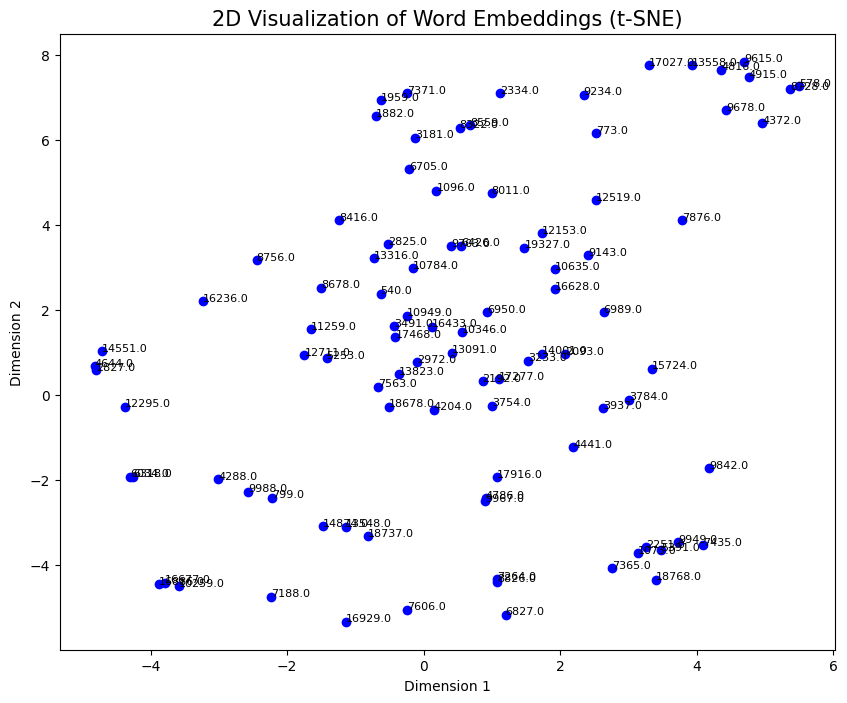


Word: opéra
Occurrences: 96
Polysemy score: 0.1640
Review ID 12711.0: [-0.09519282  0.01524655 -0.08389451  0.06992962 -0.11753962]...
Review ID 1073.0: [-0.0233054  -0.00518595 -0.06628749 -0.01264864  0.03674784]...
Review ID 10259.0: [-0.13134652  0.0312476   0.17253362 -0.0767269  -0.04452666]...
Review ID 2251.0: [ 0.02771577 -0.03844932 -0.15165207 -0.03886916  0.05270619]...
Review ID 7435.0: [ 0.01787491 -0.10134369 -0.18136714 -0.10693809  0.08464544]...
Review ID 10346.0: [-0.04567743  0.07034893  0.02768365 -0.11464955 -0.0053323 ]...
Review ID 9949.0: [-0.03368479 -0.11543937 -0.13993314 -0.11621195  0.10178228]...
Review ID 7606.0: [ 0.01071479 -0.22340125  0.16392101  0.09234544  0.03137897]...
Review ID 2334.0: [-0.04518898  0.35901666  0.2938956  -0.08914492 -0.01324536]...
Review ID 16886.0: [-0.10357419  0.22832641  0.14601386 -0.03105916  0.04091475]...
Review ID 6705.0: [-0.08491081 -0.08390567 -0.04674379 -0.07071533  0.01874515]...
Review ID 13316.0: [-0.03106572

In [3]:
target_words = ['opéra']
results = quick_polysemy_analysis(file_path, target_words, sample_size=100)
# 不知道为什么opéra换成采样200的时候python就会报错，
# 好像是pytorch处理的时候有什么问题


Analyzing word: avocat


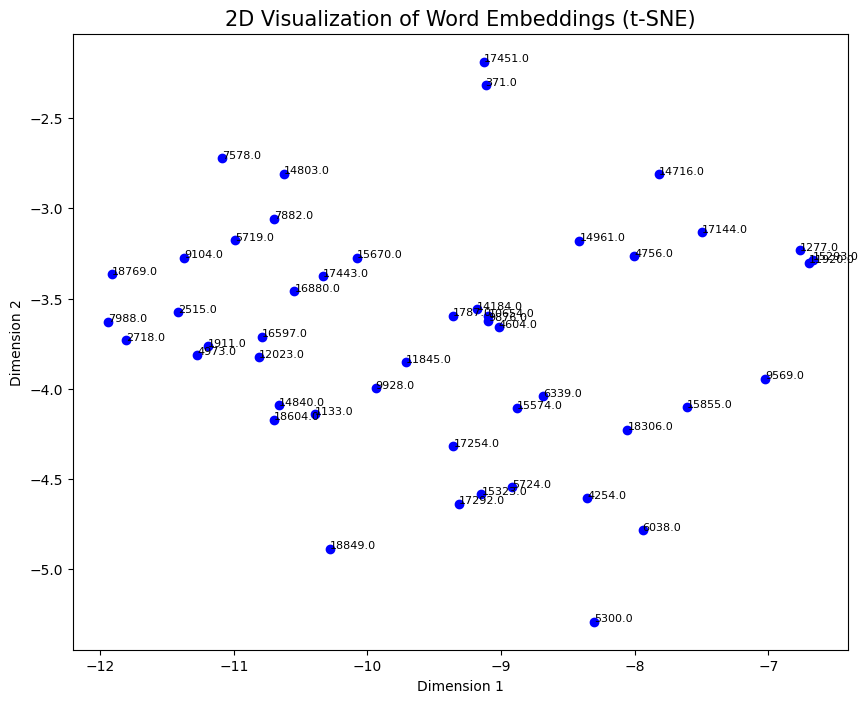


Word: avocat
Occurrences: 48
Polysemy score: 0.1092
Review ID 14184.0: [-0.09826908 -0.01388761  0.32638672  0.0317074  -0.00704017]...
Review ID 17254.0: [-0.1024994   0.09978446  0.3207519   0.05232562 -0.06888273]...
Review ID 12023.0: [ 0.07538583 -0.30020735  0.31293204  0.03114621 -0.04588264]...
Review ID 17451.0: [-0.0417942   0.00643619  0.06331705  0.05652811 -0.09933626]...
Review ID 11845.0: [-0.08503215 -0.27177355  0.3568023  -0.02847468 -0.07034312]...
Review ID 16597.0: [-0.01143073 -0.11510468  0.20736209 -0.01178841 -0.00044356]...
Review ID 5719.0: [ 0.01629641 -0.21377182  0.19448598  0.01179531 -0.06015939]...
Review ID 9104.0: [-0.01874143 -0.40792453  0.45493424 -0.02898548  0.00285208]...
Review ID 1911.0: [-0.03596506 -0.14248973  0.32324687  0.03434861 -0.07778621]...
Review ID 11920.0: [-0.0818485   0.0319718   0.07412875 -0.11508696 -0.0954679 ]...
Review ID 4604.0: [-0.06899178 -0.13499995  0.16170226 -0.03681876 -0.05528704]...
Review ID 1787.0: [-0.07026

In [4]:
target_words = ['avocat']
results = quick_polysemy_analysis(file_path, target_words, sample_size=100)


Analyzing word: bureau


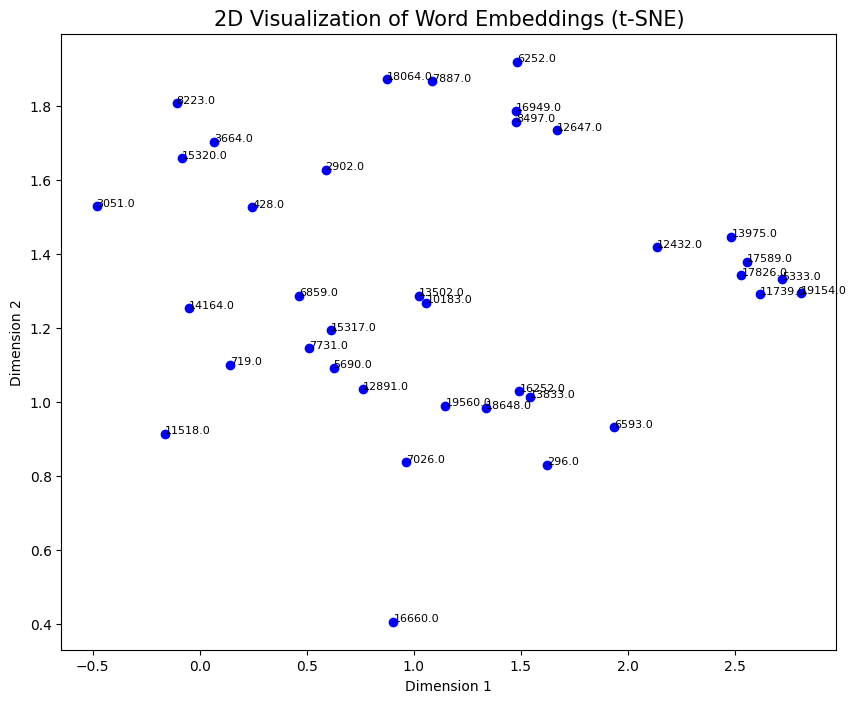


Word: bureau
Occurrences: 37
Polysemy score: 0.1470
Review ID 11518.0: [-0.03748124  0.21968728 -0.01089785 -0.05956695 -0.178989  ]...
Review ID 7887.0: [-0.04420759  0.22180554  0.10345478 -0.13295151  0.017223  ]...
Review ID 3051.0: [-0.0400084   0.1510016   0.12496528 -0.14272505 -0.09849904]...
Review ID 16660.0: [ 0.11483775  0.20865445 -0.05989716 -0.10096084 -0.1148338 ]...
Review ID 19154.0: [ 0.10800091  0.13973536 -0.25760716  0.09992494  0.04349409]...
Review ID 14164.0: [-0.12989035  0.02457075 -0.18170887  0.00932871 -0.03976591]...
Review ID 5333.0: [ 0.04138172  0.16440828 -0.24794783  0.17720883 -0.01201916]...
Review ID 15317.0: [-0.04502966 -0.1578922  -0.11980693  0.02034242 -0.07357767]...
Review ID 13975.0: [ 0.07566959  0.02566606 -0.03196475  0.15129757 -0.01445493]...
Review ID 10183.0: [-0.03328045 -0.05295298 -0.1073062   0.02649246 -0.05967229]...
Review ID 6252.0: [ 0.02856776  0.22426093  0.0614058   0.00929368 -0.0387228 ]...
Review ID 8497.0: [ 0.02656

In [5]:
target_words = ['bureau']
results = quick_polysemy_analysis(file_path, target_words, sample_size=100)

#### 样本量稍多一些的词，采样数为100/200时的对比


Analyzing word: rouge


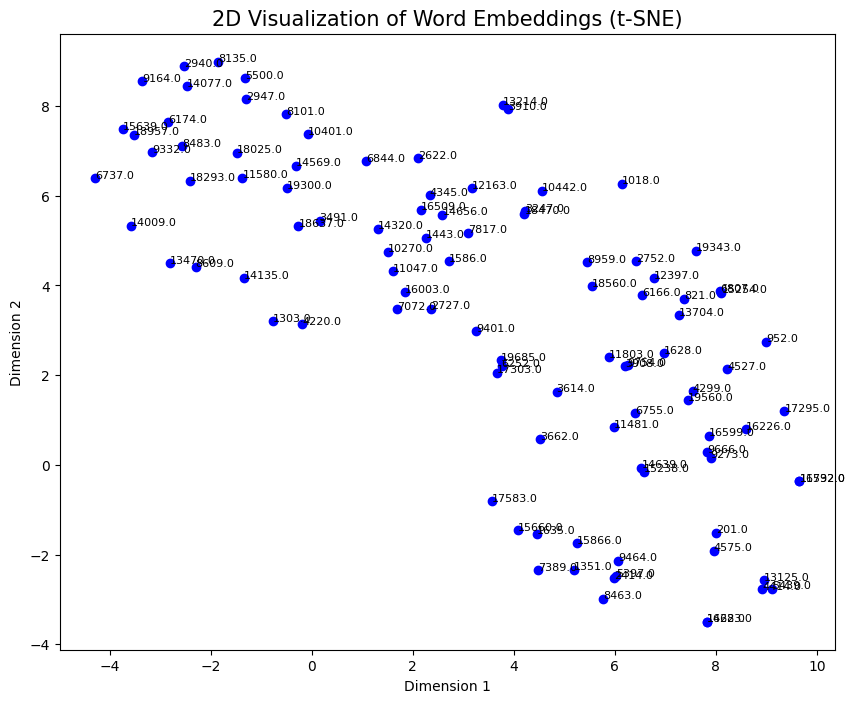


Word: rouge
Occurrences: 100
Polysemy score: 0.1468
Review ID 11047.0: [-0.01100585 -0.24367121  0.09633176  0.01425525 -0.04738686]...
Review ID 6755.0: [-0.01143787 -0.14658481  0.08373711  0.08203678  0.04391406]...
Review ID 8959.0: [ 0.00260482 -0.17988157 -0.04188418  0.00433899  0.05006041]...
Review ID 6174.0: [-0.02041492  0.12319411 -0.03018549  0.04677591  0.01942914]...
Review ID 18637.0: [-0.07305712 -0.200313   -0.05635467 -0.07174587  0.03917214]...
Review ID 9273.0: [-0.06596173 -0.46430403  0.08280432  0.03841195  0.04636724]...
Review ID 1635.0: [-0.02127355 -0.21864969  0.05332581  0.10295939  0.01373989]...
Review ID 12397.0: [-0.00030789 -0.27734917 -0.01364304 -0.10575654  0.01311695]...
Review ID 2947.0: [-0.1251843  -0.10294861 -0.09883625  0.0060405   0.14421564]...
Review ID 9332.0: [-0.07388104  0.01175697 -0.08993974  0.09801172 -0.10346991]...
Review ID 6737.0: [ 0.00746007  0.2702354  -0.14642052  0.04623223 -0.00540204]...
Review ID 7817.0: [-0.10847745 

In [6]:
target_words = ['rouge']
results = quick_polysemy_analysis(file_path, target_words, sample_size=100)


Analyzing word: rouge


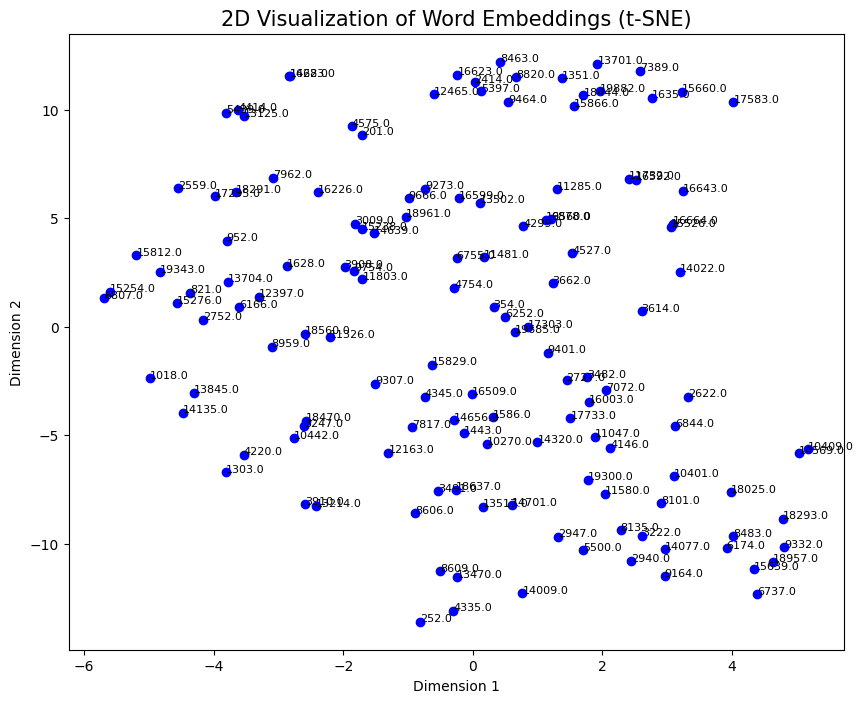


Word: rouge
Occurrences: 136
Polysemy score: 0.1485
Review ID 11047.0: [-0.01100585 -0.24367121  0.09633176  0.01425525 -0.04738686]...
Review ID 6755.0: [-0.01143787 -0.14658481  0.08373711  0.08203678  0.04391406]...
Review ID 8959.0: [ 0.00260482 -0.17988157 -0.04188418  0.00433899  0.05006041]...
Review ID 6174.0: [-0.02041492  0.12319411 -0.03018549  0.04677591  0.01942914]...
Review ID 18637.0: [-0.07305712 -0.200313   -0.05635467 -0.07174587  0.03917214]...
Review ID 9273.0: [-0.06596173 -0.46430403  0.08280432  0.03841195  0.04636724]...
Review ID 1635.0: [-0.02127355 -0.21864969  0.05332581  0.10295939  0.01373989]...
Review ID 12397.0: [-0.00030789 -0.27734917 -0.01364304 -0.10575654  0.01311695]...
Review ID 2947.0: [-0.1251843  -0.10294861 -0.09883625  0.0060405   0.14421564]...
Review ID 9332.0: [-0.07388104  0.01175697 -0.08993974  0.09801172 -0.10346991]...
Review ID 6737.0: [ 0.00746007  0.2702354  -0.14642052  0.04623223 -0.00540204]...
Review ID 7817.0: [-0.10847745 

In [7]:
target_words = ['rouge']
results = quick_polysemy_analysis(file_path, target_words, sample_size=200)


Analyzing word: carte


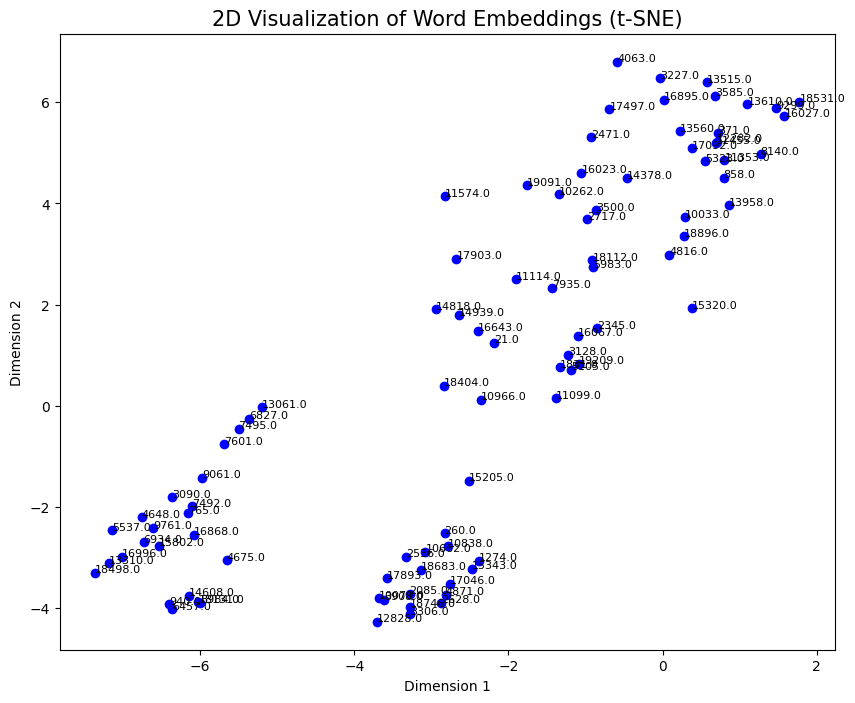


Word: carte
Occurrences: 91
Polysemy score: 0.2017
Review ID 13515.0: [-0.09739526  0.22611952 -0.06554797  0.00891011  0.06077262]...
Review ID 9299.0: [-0.02040839  0.43099886 -0.25826508  0.08422412  0.0658479 ]...
Review ID 11114.0: [-0.09424193  0.14339781 -0.16163269  0.00625283  0.05057091]...
Review ID 10079.0: [ 0.00566061  0.09188987 -0.02428986  0.19286166 -0.08358805]...
Review ID 15802.0: [-0.03029492  0.19962448 -0.15159762  0.26079425 -0.00361181]...
Review ID 3227.0: [ 0.00512006  0.38953453 -0.3304835  -0.02280198  0.09513839]...
Review ID 13061.0: [-0.01035636  0.20890889 -0.12677434  0.24788027 -0.00534561]...
Review ID 12828.0: [ 0.03277437  0.06720001 -0.10885408  0.1908938  -0.01830762]...
Review ID 18131.0: [ 0.00907368  0.27355686 -0.03525553  0.23288327 -0.00487238]...
Review ID 2085.0: [-0.01689576  0.16293874 -0.05530068  0.15094993  0.03283637]...
Review ID 12282.0: [-0.02872918  0.42914852 -0.11634512 -0.05765582  0.07907728]...
Review ID 1274.0: [-0.09512

In [8]:
target_words = ['carte']
results = quick_polysemy_analysis(file_path, target_words, sample_size=100)



Analyzing word: carte


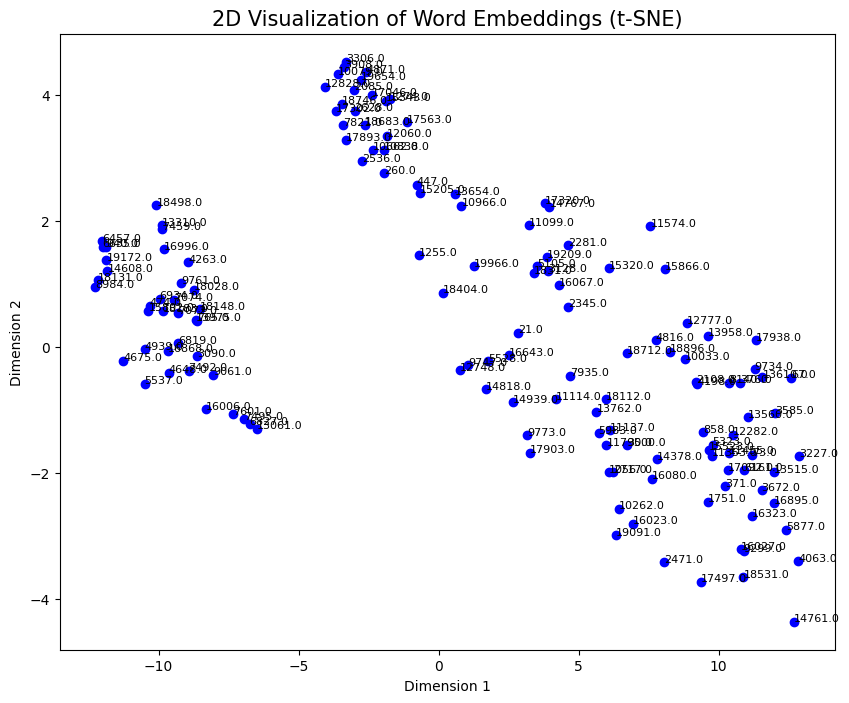


Word: carte
Occurrences: 143
Polysemy score: 0.1999
Review ID 13515.0: [-0.09739526  0.22611952 -0.06554797  0.00891011  0.06077262]...
Review ID 9299.0: [-0.02040839  0.43099886 -0.25826508  0.08422412  0.0658479 ]...
Review ID 11114.0: [-0.09424193  0.14339781 -0.16163269  0.00625283  0.05057091]...
Review ID 10079.0: [ 0.00566061  0.09188987 -0.02428986  0.19286166 -0.08358805]...
Review ID 15802.0: [-0.03029492  0.19962448 -0.15159762  0.26079425 -0.00361181]...
Review ID 3227.0: [ 0.00512006  0.38953453 -0.3304835  -0.02280198  0.09513839]...
Review ID 13061.0: [-0.01035636  0.20890889 -0.12677434  0.24788027 -0.00534561]...
Review ID 12828.0: [ 0.03277437  0.06720001 -0.10885408  0.1908938  -0.01830762]...
Review ID 18131.0: [ 0.00907368  0.27355686 -0.03525553  0.23288327 -0.00487238]...
Review ID 2085.0: [-0.01689576  0.16293874 -0.05530068  0.15094993  0.03283637]...
Review ID 12282.0: [-0.02872918  0.42914852 -0.11634512 -0.05765582  0.07907728]...
Review ID 1274.0: [-0.0951

In [9]:
target_words = ['carte']
results = quick_polysemy_analysis(file_path, target_words, sample_size=200)



Analyzing word: règle


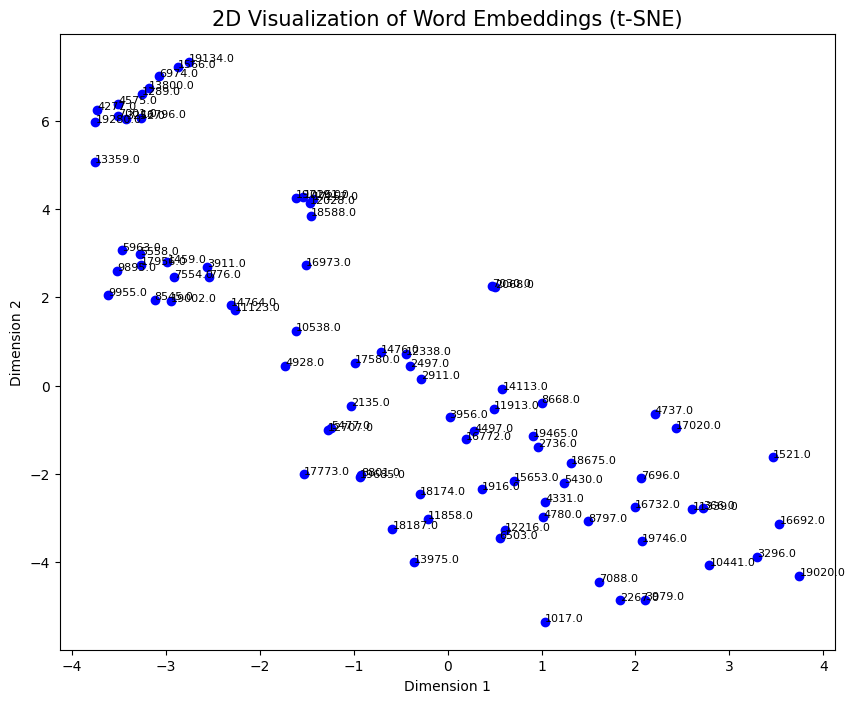


Word: règle
Occurrences: 83
Polysemy score: 0.1645
Review ID 16732.0: [-0.0883714  -0.0308225   0.01493252  0.2406936   0.0568056 ]...
Review ID 1017.0: [ 0.07184795  0.14088388 -0.01852841  0.05202695 -0.09364691]...
Review ID 7001.0: [-0.06942271 -0.38414457  0.1354794   0.16257963 -0.01163493]...
Review ID 3911.0: [ 0.08641718 -0.02123497  0.02526887  0.30825692  0.1721022 ]...
Review ID 19746.0: [ 0.01957839  0.18915501 -0.15119061  0.12733519 -0.04073204]...
Review ID 11913.0: [-0.06916559  0.08822092  0.02002723  0.20666486  0.11222584]...
Review ID 1566.0: [-0.09706517 -0.22920349  0.02302317  0.185246   -0.04923127]...
Review ID 16772.0: [-0.01064713  0.03011282 -0.04469099  0.23154268  0.05052537]...
Review ID 12338.0: [0.01415978 0.13173082 0.06574669 0.21137536 0.13777126]...
Review ID 2736.0: [-0.03171381  0.18029508  0.04628484  0.12035861  0.10579222]...
Review ID 17580.0: [0.02110901 0.02776822 0.12838155 0.24155137 0.14746077]...
Review ID 4331.0: [-0.02105572  0.19018

In [10]:
target_words = ['règle']
results = quick_polysemy_analysis(file_path, target_words, sample_size=100)


Analyzing word: règle


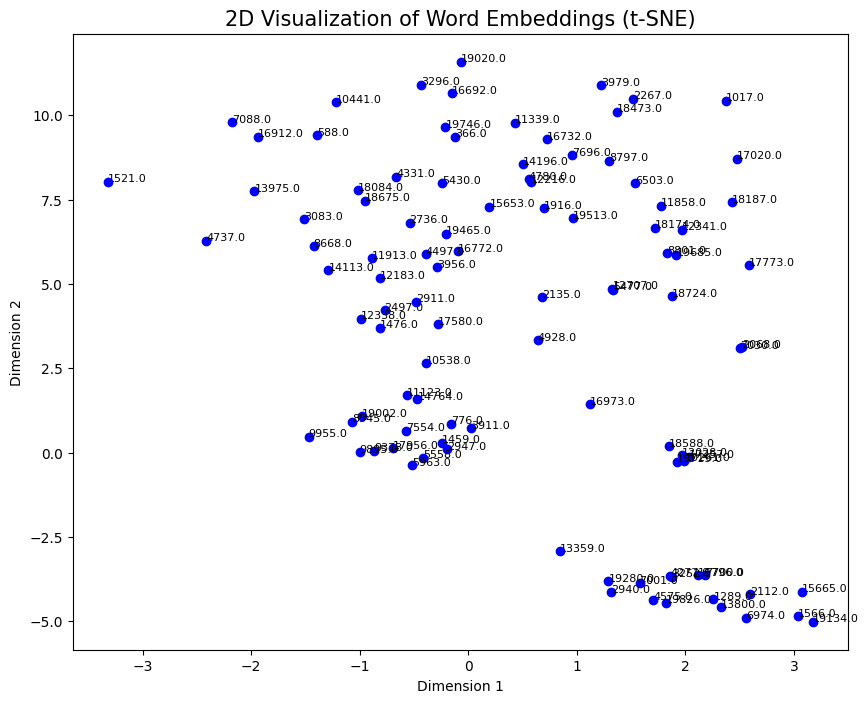


Word: règle
Occurrences: 100
Polysemy score: 0.1655
Review ID 16732.0: [-0.0883714  -0.0308225   0.01493252  0.2406936   0.0568056 ]...
Review ID 1017.0: [ 0.07184795  0.14088388 -0.01852841  0.05202695 -0.09364691]...
Review ID 7001.0: [-0.06942271 -0.38414457  0.1354794   0.16257963 -0.01163493]...
Review ID 3911.0: [ 0.08641718 -0.02123497  0.02526887  0.30825692  0.1721022 ]...
Review ID 19746.0: [ 0.01957839  0.18915501 -0.15119061  0.12733519 -0.04073204]...
Review ID 11913.0: [-0.06916559  0.08822092  0.02002723  0.20666486  0.11222584]...
Review ID 1566.0: [-0.09706517 -0.22920349  0.02302317  0.185246   -0.04923127]...
Review ID 16772.0: [-0.01064713  0.03011282 -0.04469099  0.23154268  0.05052537]...
Review ID 12338.0: [0.01415978 0.13173082 0.06574669 0.21137536 0.13777126]...
Review ID 2736.0: [-0.03171381  0.18029508  0.04628484  0.12035861  0.10579222]...
Review ID 17580.0: [0.02110901 0.02776822 0.12838155 0.24155137 0.14746077]...
Review ID 4331.0: [-0.02105572  0.1901

In [11]:
target_words = ['règle']
results = quick_polysemy_analysis(file_path, target_words, sample_size=200)


Analyzing word: film


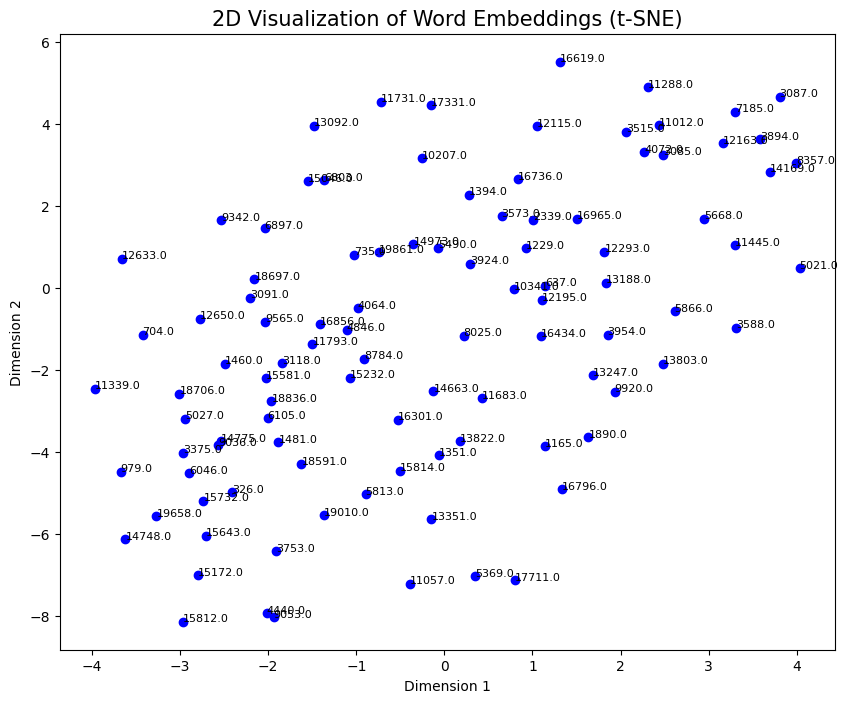


Word: film
Occurrences: 100
Polysemy score: 0.0617
Review ID 3085.0: [-0.00617757  0.08012205  0.04033831  0.0716937  -0.03461219]...
Review ID 7185.0: [ 0.01962392  0.05426341 -0.1220694   0.04393309 -0.02248933]...
Review ID 6046.0: [-0.02709399 -0.01477001 -0.00614804  0.02687391 -0.07252597]...
Review ID 735.0: [-0.04801951  0.05550154  0.01250601  0.07794119 -0.06189098]...
Review ID 12163.0: [-0.03805809 -0.01965368 -0.02936942  0.1166457  -0.04315253]...
Review ID 9565.0: [-0.04306974 -0.01640072  0.00744835  0.09329566 -0.08440148]...
Review ID 6803.0: [-0.02549986  0.02177148 -0.01800404  0.07340627 -0.13394643]...
Review ID 3091.0: [ 0.01597877 -0.04340354 -0.03007011  0.04655272 -0.0634533 ]...
Review ID 15172.0: [-0.01726966  0.07501398  0.02965029 -0.00707126 -0.06586987]...
Review ID 13188.0: [-0.04651611 -0.08777627 -0.10140895  0.06099004 -0.06391091]...
Review ID 18697.0: [ 0.02780768 -0.07941841 -0.00448819 -0.01421789 -0.06921598]...
Review ID 3118.0: [-0.0410833  -

In [15]:
target_words = ['film']
results = quick_polysemy_analysis(file_path, target_words, sample_size=100)


Analyzing word: film


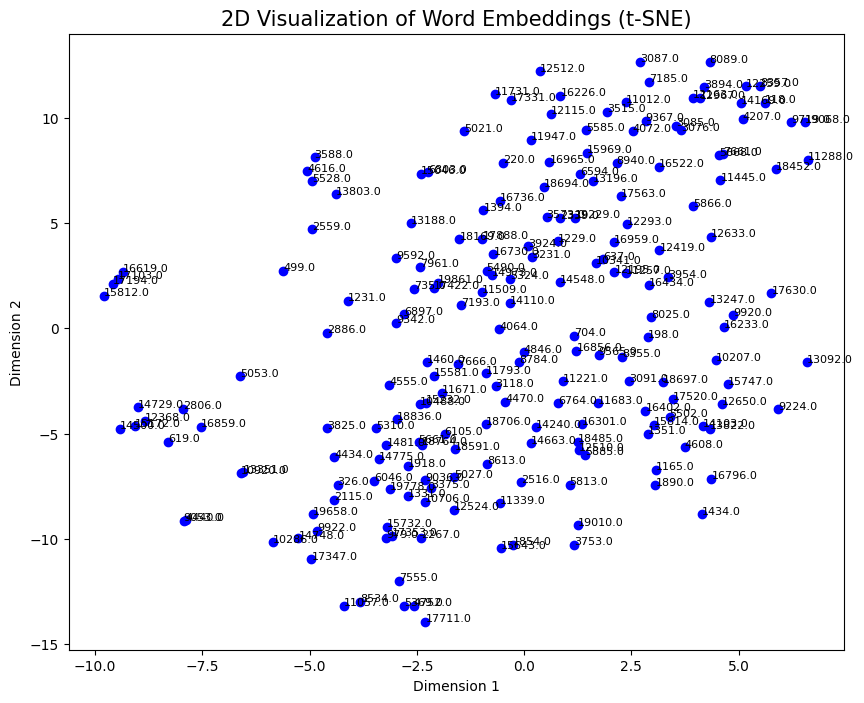


Word: film
Occurrences: 200
Polysemy score: 0.0587
Review ID 3085.0: [-0.00617757  0.08012205  0.04033831  0.0716937  -0.03461219]...
Review ID 7185.0: [ 0.01962392  0.05426341 -0.1220694   0.04393309 -0.02248933]...
Review ID 6046.0: [-0.02709399 -0.01477001 -0.00614804  0.02687391 -0.07252597]...
Review ID 735.0: [-0.04801951  0.05550154  0.01250601  0.07794119 -0.06189098]...
Review ID 12163.0: [-0.03805809 -0.01965368 -0.02936942  0.1166457  -0.04315253]...
Review ID 9565.0: [-0.04306974 -0.01640072  0.00744835  0.09329566 -0.08440148]...
Review ID 6803.0: [-0.02549986  0.02177148 -0.01800404  0.07340627 -0.13394643]...
Review ID 3091.0: [ 0.01597877 -0.04340354 -0.03007011  0.04655272 -0.0634533 ]...
Review ID 15172.0: [-0.01726966  0.07501398  0.02965029 -0.00707126 -0.06586987]...
Review ID 13188.0: [-0.04651611 -0.08777627 -0.10140895  0.06099004 -0.06391091]...
Review ID 18697.0: [ 0.02780768 -0.07941841 -0.00448819 -0.01421789 -0.06921598]...
Review ID 3118.0: [-0.0410833  -

In [16]:
target_words = ['film']
results = quick_polysemy_analysis(file_path, target_words, sample_size=200)


Analyzing word: histoire


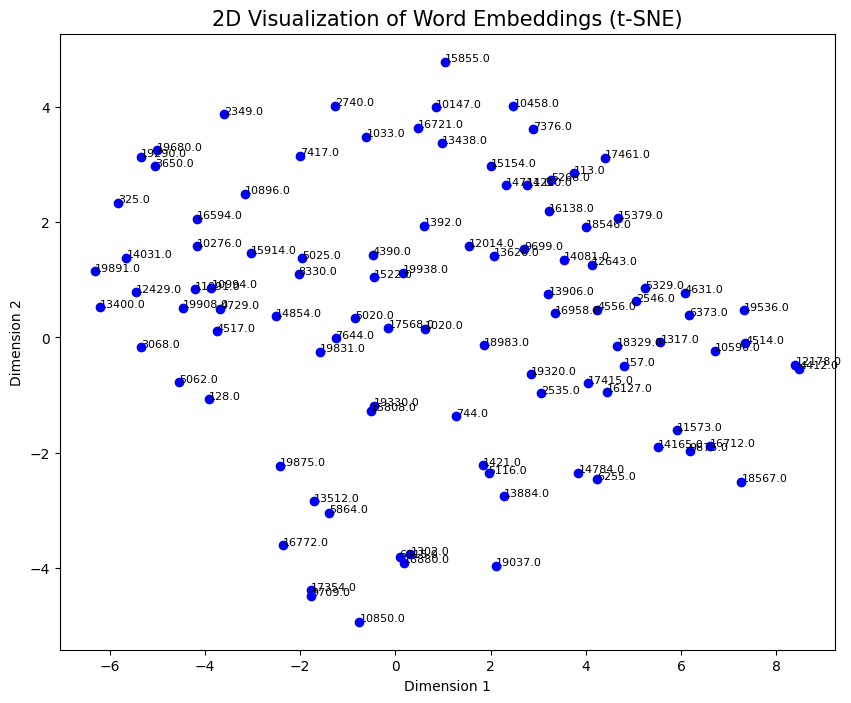


Word: histoire
Occurrences: 100
Polysemy score: 0.0764
Review ID 5268.0: [ 0.05516269  0.02380287 -0.04886458  0.10955942 -0.06240742]...
Review ID 16712.0: [ 0.05198253 -0.187143    0.17577052  0.08268438 -0.04133593]...
Review ID 14784.0: [ 0.06212775  0.18925078  0.03103589  0.04334766 -0.05187218]...
Review ID 8330.0: [-0.06027339  0.16714057  0.06318041 -0.05959804 -0.12672004]...
Review ID 10590.0: [ 0.04417044  0.00365175  0.12965848  0.11145547 -0.10390661]...
Review ID 10994.0: [-0.03086266  0.08658022  0.259373   -0.02939288 -0.18922186]...
Review ID 13438.0: [ 0.02709864  0.08862762  0.05928737 -0.0110289  -0.08592655]...
Review ID 3650.0: [ 0.00585022  0.00624857  0.23374656  0.06247403 -0.15805218]...
Review ID 19938.0: [ 0.00145708  0.2500003   0.10494784 -0.02551173 -0.09726325]...
Review ID 1302.0: [ 0.0233777   0.01879429  0.02794173  0.04250826 -0.13015875]...
Review ID 10896.0: [ 0.02967384  0.24132837 -0.05054047  0.04322344 -0.15230191]...
Review ID 4412.0: [-0.03

In [13]:
target_words = ['histoire']
results = quick_polysemy_analysis(file_path, target_words, sample_size=100)


Analyzing word: histoire


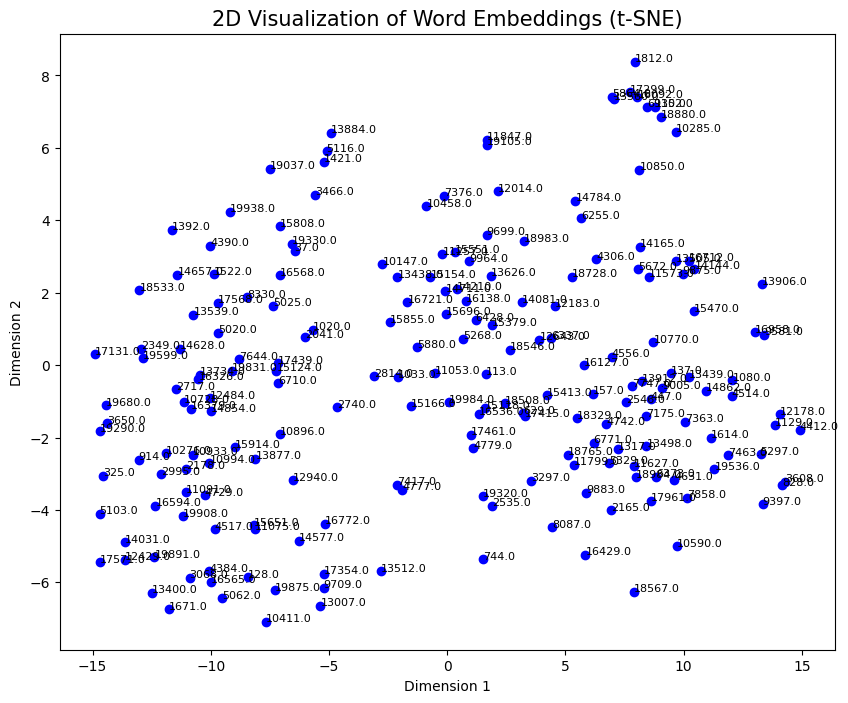


Word: histoire
Occurrences: 200
Polysemy score: 0.0726
Review ID 5268.0: [ 0.05516269  0.02380287 -0.04886458  0.10955942 -0.06240742]...
Review ID 16712.0: [ 0.05198253 -0.187143    0.17577052  0.08268438 -0.04133593]...
Review ID 14784.0: [ 0.06212775  0.18925078  0.03103589  0.04334766 -0.05187218]...
Review ID 8330.0: [-0.06027339  0.16714057  0.06318041 -0.05959804 -0.12672004]...
Review ID 10590.0: [ 0.04417044  0.00365175  0.12965848  0.11145547 -0.10390661]...
Review ID 10994.0: [-0.03086266  0.08658022  0.259373   -0.02939288 -0.18922186]...
Review ID 13438.0: [ 0.02709864  0.08862762  0.05928737 -0.0110289  -0.08592655]...
Review ID 3650.0: [ 0.00585022  0.00624857  0.23374656  0.06247403 -0.15805218]...
Review ID 19938.0: [ 0.00145708  0.2500003   0.10494784 -0.02551173 -0.09726325]...
Review ID 1302.0: [ 0.0233777   0.01879429  0.02794173  0.04250826 -0.13015875]...
Review ID 10896.0: [ 0.02967384  0.24132837 -0.05054047  0.04322344 -0.15230191]...
Review ID 4412.0: [-0.03

In [14]:
target_words = ['histoire']
results = quick_polysemy_analysis(file_path, target_words, sample_size=200)